# SHA-256 en Python

### Auteur : Léopold Terpereau
Basé sur le rapport du National Institute of Standards and Technology:
    https://csrc.nist.gov/csrc/media/publications/fips/180/2/archive/2002-08-01/documents/fips180-2.pdf

Chaque définition de fonction est suivie d'un exemple

## Modules utilisés

In [1]:

import numpy as np
import math
import matplotlib.pyplot as plt
import random as r
import hashlib
import re
import time
import qrcode
%matplotlib inline

### Annexe : Définition des fonctions binaires bit à bit

In [2]:
a='11'*16
b='01'*16
c='0'*16+'1'*16
print('a = ' + a)
print('b = ' + b)
print('c = ' + c)

a = 11111111111111111111111111111111
b = 01010101010101010101010101010101
c = 00000000000000001111111111111111


Addition modulo $2^{32}$ de a et b

In [3]:
def ADD32(a,b): 
    if len(a)!=len(b) or len(a)!=32:
        raise Exception
    a=a[::-1]
    b=b[::-1]
    s=''
    k=0
    for i in range(32):
        if a[i]==b[i] and a[i]=='1':
            if k==1:
                s+='1'
            else:
                s+='0'
            k=1
        elif a[i]==b[i] and a[i]=='0':
            if k==1:
                s+='1'
            else:
                s+='0'
            k=0
        else:
            if k==1:
                s+='0'
            else:
                s+='1'
    s=s[::-1]
    return s

print('  a + b \n')
print('  ' + a)
print('+ ' + b)
print('= ' + ADD32(a,b))



  a + b 

  11111111111111111111111111111111
+ 01010101010101010101010101010101
= 01010101010101010101010101010100



Fonction NON, ET, OU, OU EXCLUSIF binaires

In [4]:

def NOT(a):#a est codé en binaire 
    l=len(a)
    s=''
    for i in range(l):
        s+=str(1-int(a[i]))
    return s

def AND(a,b):#a et b sont codés en binaire 
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        s+=str(int(a[i])*int(b[i]))
    return s

def OR(a,b):#a et b sont codés en binaire 
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        if int(a[i])==1 or int(b[i])==1:
            s+='1'
        else :
            s+='0'
    return s

def XOR(a,b):#a est codé en binaire
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        s+=str((int(a[i])+int(b[i]))%2)
    return s

def multiXOR(L): #liste de mots binaires supposés de même longueur
    l=len(L[0])
    s=''
    for i in range(l):
        val=0
        for mot in L:
            val+=int(mot[i])
        s+=str(val%2)
    return s




In [5]:

print('    a = ' + a)
print('NON a = ' + NOT(a))

    a = 11111111111111111111111111111111
NON a = 00000000000000000000000000000000


In [6]:

print('   ' + a)
print('ET ' + b)
print(' = ' + AND(a,b))

   11111111111111111111111111111111
ET 01010101010101010101010101010101
 = 01010101010101010101010101010101


In [7]:

print('   ' + a)
print('OU ' + b)
print(' = ' + OR(a,b))

   11111111111111111111111111111111
OU 01010101010101010101010101010101
 = 11111111111111111111111111111111


In [8]:

print('      ' + a)
print('OU EX ' + b)
print('    = ' + XOR(a,b))

      11111111111111111111111111111111
OU EX 01010101010101010101010101010101
    = 10101010101010101010101010101010


Fonctions de Rotation et Decalage binaires

$SHIFTR^{n}(x)=x>>n$

$ROTR^{n}(x)=(x>>n) ou (x<<(32-n))$

In [9]:
def DecalageDroite(a,n):
    l=len(a)
    s=''
    s+='0'*n
    s+=str(a[:l-n])
    return s

def RotationDroite(a,n): 
    l=len(a)
    s=''
    s+=str(a[-n:])
    s+=str(a[:l-n])
    return s    
print('      c = ' + c)
print('DecD5 c = ' + DecalageDroite(c,5))
print('RotD5 c = ' + RotationDroite(c,5))

      c = 00000000000000001111111111111111
DecD5 c = 00000000000000000000011111111111
RotD5 c = 11111000000000000000011111111111


Fonctions composées $Sigma$

∑0(x) = ROTR 2(x) ⊕ ROTR 13(x) ⊕ ROTR 22(x)

∑1(x) = ROTR 6(x) ⊕ ROTR 11(x) ⊕ ROTR 25(x)

σ0(x) = ROTR 7(x) ⊕ ROTR 18(x) ⊕ SHR 3(x)

σ1(x) = ROTR 17(x) ⊕ ROTR 19(x) ⊕ SHR 10(x)

In [10]:
def SIGMA0(a):
    a0=RotationDroite(a, 2)
    a1=RotationDroite(a, 13)
    a2=RotationDroite(a, 22)
    a3=multiXOR((a0,a1,a2))
    return a3
    
def SIGMA1(a):
    a0=RotationDroite(a, 6)
    a1=RotationDroite(a, 11)
    a2=RotationDroite(a, 25)
    a3=multiXOR((a0,a1,a2))
    return a3

def sigma0(a):
    a0=RotationDroite(a, 7)
    a1=RotationDroite(a, 18)
    a2=DecalageDroite(a, 3)
    a3=multiXOR((a0,a1,a2))
    return a3
    
def sigma1(a):
    a0=RotationDroite(a, 17)
    a1=RotationDroite(a, 19)
    a2=DecalageDroite(a, 10)
    a3=multiXOR((a0,a1,a2))
    return a3




Fonctions particulières $Choix$ et $Majorité$

Ch(x, y,z) = (x ∧ y) ⊕ (¬x ∧ z)

Maj(x, y,z) = (x ∧ y) ⊕ (x ∧ z) ⊕ ( y ∧ z)

In [11]:

def Choix(a,b,c):
    if len(a)!=len(b) or len(b)!=len(c):
        raise Exception
    l=len(a)
    r=''
    for i in range(l):
        if a[i]=='0':
            r+=c[i]
        else:
            r+=b[i]
    return r



def Maj(a,b,c):
    if len(a)!=len(b) or len(b)!=len(c):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        k=0
        if a[i]=='1':
            k+=1
        if b[i]=='1':
            k+=1
        if c[i]=='1':
            k+=1
        if k>1:
            s+='1'
        else:
            s+='0'
    return s



In [12]:
print('->       ' + c)
print('Choix 1  ' + b)
print('Choix 0  ' + a)
print('\n')
print('Choix 1  ' + ' '*16 + b[:16])
print('Choix 0  ' + a[-16:] + ' '*16)


print('      =  ' + Choix(c,b,a))


->       00000000000000001111111111111111
Choix 1  01010101010101010101010101010101
Choix 0  11111111111111111111111111111111


Choix 1                  0101010101010101
Choix 0  1111111111111111                
      =  11111111111111110101010101010101


In [13]:

print(' a    ' + a)
print(' b    ' + b)
print(' c    ' + c)
print('Maj = ' + Maj(a,b,c))

 a    11111111111111111111111111111111
 b    01010101010101010101010101010101
 c    00000000000000001111111111111111
Maj = 01010101010101011111111111111111


## I. Pré-traitement

### Conversion 
Conversion du message en ascii puis en binaire (sur 8 bits), en itérant sur chaque caractère

In [14]:
def strBin(message): 
    return (''.join(format(ord(car),'08b') for car in message)) 

In [15]:
def strBinDecomposition(message):
    car_list = [car for car in message]
    ascii_list = [ord(car) for car in car_list]
    bit_list = [format(number,'08b') for number in ascii_list]
    print(car_list)
    print(ascii_list)
    print(bit_list)

#### Exemple : Conversion en binaire du message 'abc'

In [16]:
strBinDecomposition('abc')

['a', 'b', 'c']
[97, 98, 99]
['01100001', '01100010', '01100011']


In [17]:
strBin('abc')

'011000010110001001100011'

### Rembourrage
Rembourre le message selon le procédé de Padding :
 
Ajoute un 1 après le message converti en binaire, puis ajoute des 0, et enfin la longueur du message initial en binaire sur 64 bits

In [18]:
def rembourrage(message):
    rembourré=strBin(message)               #utilisation de la fonction précedente
    l=len(rembourré)+2**64                  #ajout de 2**64 pour coder la longueur sur 64 bits
    rembourré+='1'
    while len(rembourré)%512!=448:          #ajout de 0 jusqu'à une longueur de 448 modulo 512
        rembourré+='0'
    rembourré+=bin(l)[-64:]                 #ajout de la longueur l en binaire du message initial
    return(rembourré)

Exemple :
Rembourrage du message 'abc'

In [19]:
test=rembourrage('abc')
print("Le message en binaire")
print(strBin('abc'),'\n')
print("On rajoute 1 puis des 0 jusqu\'à atteindre une longueur de 448 modulo 512")
print(test[:448],'\n')
print("Et la longueur du message binaire, codé sur 64 bits" )
print("24 = 00...0011000")
print(test,'\n')
print("Longueur finale : " + str(len(test)) + " bits")

Le message en binaire
011000010110001001100011 

On rajoute 1 puis des 0 jusqu'à atteindre une longueur de 448 modulo 512
0110000101100010011000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000 

Et la longueur du message binaire, codé sur 64 bits
24 = 00...0011000
011000010110001001100011100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

### Découpage en blocs
Découpe un ensemble de bits en blocs de 512 bits

In [20]:
def découpageBlocs(rembourré):
    listeblocs=[]
    for i in range(len(rembourré)//512):
        listeblocs.append(str(rembourré[i*512:(i+1)*512]))
    return listeblocs  #liste contenant les blocs

#### Exemple : Découpage du message 'abc' rembourré 

On remarque qu'on a alors une liste d'1 bloc de 512 bits

In [21]:
test=découpageBlocs(test)
print(test)
len(test)

['01100001011000100110001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000']


1

### Division en mots
Un bloc de 512 bits est divisé en une liste 'mots' de 16 mots de 32 bits

In [22]:
def division32bits(bloc):
    mots=[]
    for i in range(512//32):
        mots.append(str(bloc[i*32:(i+1)*32]))
    return mots                                #liste contenant les mots

#### Exemple : Découpage du bloc précédent

In [23]:
division32bits(test[0])


['01100001011000100110001110000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000011000']

### Annexe : Fonction d'affichage

In [24]:
def afficheTableau(tab):
    plt.figure(figsize=(10, 10))
    plt.imshow(tab,'Greys',vmin=0,vmax=1)
    
def enBits(liste):
    listeBits=[[] for i in range(len(liste))]
    for i in range(len(liste)):
        for j in range(len(liste[i])):
            listeBits[i].append(float(liste[i][j]))
    return listeBits
            
# Attends juste quelques cellules et tu vas comprendre 


## II. Expansion
On transforme les 16 mots d'une liste en 64 mots en les recombinant avec une relation de récurrence


$$   
W_t = \begin{cases}
M_t & 0\leq t \leq 15\\
\sigma{_1}(W_{t-2}) + W_{t-7} + \sigma{_0}(W_{t-15}) + W_{t-16} & 16\leq t \leq 63\\
\end{cases}
$$

In [25]:
def expansion(M): 
    mots=division32bits(M) 
    for t in range(16,64):
        m=ADD32(sigma1(mots[t-2]),mots[t-7])
        m=ADD32(m,sigma0(mots[t-15]))
        m=ADD32(m,mots[t-16])
        mots.append(m)
    return mots

#### Exemple : Expansion de la liste des mots précédente

La ième ligne représente le ième mot (0=blanc et 1=noir)

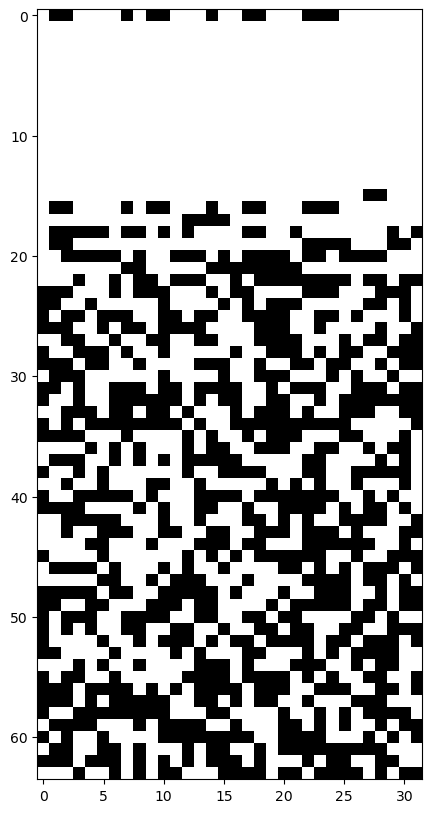

In [26]:
afficheTableau(enBits(expansion(test[0])))

### Importation des constantes de SHA-256


In [27]:
ListeConstantes= "428a2f98 71374491 b5c0fbcf e9b5dba5 3956c25b 59f111f1 923f82a4 ab1c5ed5 d807aa98 12835b01 243185be 550c7dc3 72be5d74 80deb1fe 9bdc06a7 c19bf174 e49b69c1 efbe4786 0fc19dc6 240ca1cc 2de92c6f 4a7484aa 5cb0a9dc 76f988da 983e5152 a831c66d b00327c8 bf597fc7 c6e00bf3 d5a79147 06ca6351 14292967 27b70a85 2e1b2138 4d2c6dfc 53380d13 650a7354 766a0abb 81c2c92e 92722c85 a2bfe8a1 a81a664b c24b8b70 c76c51a3 d192e819 d6990624 f40e3585 106aa070 19a4c116 1e376c08 2748774c 34b0bcb5 391c0cb3 4ed8aa4a 5b9cca4f 682e6ff3 748f82ee 78a5636f 84c87814 8cc70208 90befffa a4506ceb bef9a3f7 c67178f2"

K=[]
for k in ListeConstantes.split() :
    K.append(bin(int(k,16)+2**32)[3:])

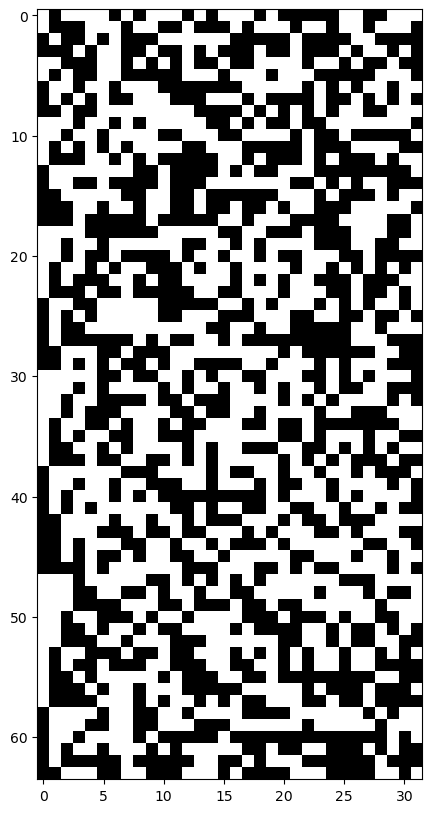

In [28]:
afficheTableau(enBits(K))
#les fameuses constantes

### Importation des hachés initiaux de SHA-256

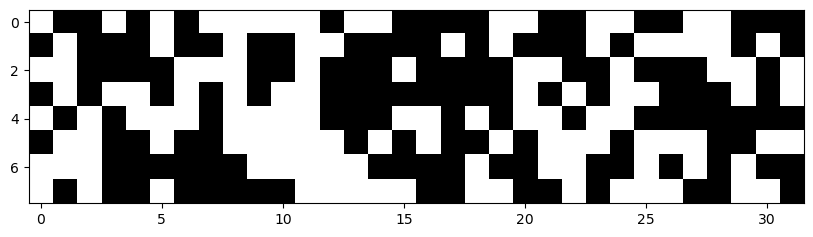

In [29]:
h0 = bin(int('6a09e667',16)+2**32)[3:]
h1 = bin(int('bb67ae85',16)+2**32)[3:]
h2 = bin(int('3c6ef372',16)+2**32)[3:]
h3 = bin(int('a54ff53a',16)+2**32)[3:]
h4 = bin(int('510e527f',16)+2**32)[3:]
h5 = bin(int('9b05688c',16)+2**32)[3:]
h6 = bin(int('1f83d9ab',16)+2**32)[3:]
h7 = bin(int('5be0cd19',16)+2**32)[3:]
H=[h0,h1,h2,h3,h4,h5,h6,h7]
afficheTableau(enBits(H))


## III. Fonction de mise à jour des états du registre
C'est-à-dire la fonction qui hache les mots, de manière récursive


$$
\begin{array}{r c l l}
      0\leq i \leq 62 \\
      A_{i+1} & = & \Sigma_1(E_i) + Ch(E_i,F_i,G_i) + H_i + W_i + K_i + \Sigma_0(A_i) + Maj(A_i,B_i,C_i)   & & A_0 = h_0  \\
      B_{i+1} & = & A_i          & & B_0 = h_1\\      
      C_{i+1} & = & B_i          & & C_0 = h_2\\
      D_{i+1} & = & C_i          & & D_0 = h_3\\
      E_{i+1} & = & \Sigma_1(E_i) + Ch(E_i,F_i,G_i) + H_i + W_i + K_i + D_i   & & E_0 = h_4     \\
      F_{i+1} & = & E_i          & & F_0 = h_5\\
      G_{i+1} & = & F_i          & & G_0 = h_6\\
      H_{i+1} & = & G_i          & & H_0 = h_7\\
   \end{array}
$$

In [30]:
def MAJetatRegistre(H,M):
    a=H[0]
    b=H[1]
    c=H[2]
    d=H[3]
    e=H[4]
    f=H[5]
    g=H[6]
    h=H[7]
    for t in range(64):
        T1=ADD32(ADD32(h,SIGMA1(e)),ADD32(Choix(e,f,g),ADD32(K[t],M[t])))
        T2=ADD32(SIGMA0(a),Maj(a,b,c))
        h=g
        g=f
        f=e
        e=ADD32(d,T1)
        d=c
        c=b
        b=a
        a=ADD32(T1,T2)
    H[0]=ADD32(a,H[0])
    H[1]=ADD32(b,H[1])
    H[2]=ADD32(c,H[2])
    H[3]=ADD32(d,H[3])
    H[4]=ADD32(e,H[4])
    H[5]=ADD32(f,H[5])
    H[6]=ADD32(g,H[6])
    H[7]=ADD32(h,H[7])
    return H

### Etapes de calcul du haché

Le haché initial du premier bloc est défini par h0 jusqu'à h7, qui correspondent aux mots $a$ à $h$ initialement

On calcule le haché intermédiaire de chaque bloc (de 512 bits) en concatenant les mots A à H, qui est réutilisé comme haché initial pour le traitement du bloc suivant 


$$
[A_{63},B_{63},C_{63},D_{63},E_{63},F_{63},G_{63},H_{63}]
$$

In [31]:
def etapes(L):
    l=len(L)
    h0 = bin(int('6a09e667',16)+2**32)[3:]
    h1 = bin(int('bb67ae85',16)+2**32)[3:]
    h2 = bin(int('3c6ef372',16)+2**32)[3:]
    h3 = bin(int('a54ff53a',16)+2**32)[3:]
    h4 = bin(int('510e527f',16)+2**32)[3:]
    h5 = bin(int('9b05688c',16)+2**32)[3:]
    h6 = bin(int('1f83d9ab',16)+2**32)[3:]
    h7 = bin(int('5be0cd19',16)+2**32)[3:]
    H=[h0,h1,h2,h3,h4,h5,h6,h7]
    for i in range(1,l+1):
        M=expansion(L[i-1])
        H=MAJetatRegistre(H,M)
    H=H[0]+H[1]+H[2]+H[3]+H[4]+H[5]+H[6]+H[7]
    return H

Exemple : calcul du haché en bit du message $abc$

            haché binaire :  1011101001111000000101101011111110001111000000011100111111101010010000010100000101000000110111100101110110101110001000100010001110110000000000110110000110100011100101100001011101111010100111001011010000010000111111110110000111110010000000000001010110101101
longueur du haché binaire :  256


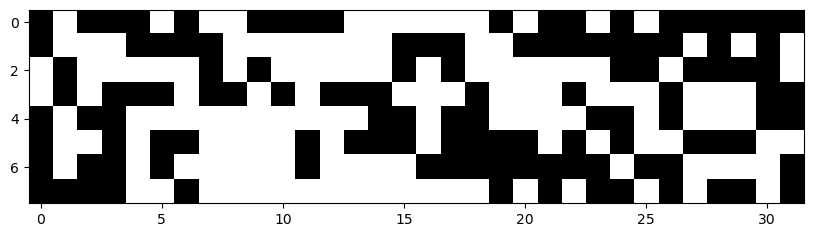

In [32]:
R=rembourrage('abc')    
L=découpageBlocs(R)
H=etapes(L)
print('            haché binaire : ',H)
print('longueur du haché binaire : ',len(H))
list_H=[H[i*32:(i+1)*32] for i in range(8)]
afficheTableau(enBits(list_H))

### Calcul du hexdigest
On transforme le haché final de 256 bits en hexadécimal (suite de 64 caractères)

In [33]:
def digest(H): #renvoie un hexdigest du haché 
    d=hex(int(H, 2))[2:]
    return d

#### Exemple : conversion binaire en hexadécimal

In [34]:
digest('10101001111111111110')

'a9ffe'

#### Exemple : calcul du haché en hexadécimal du message $abc$

In [35]:
digest(H)

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'

On peut comparer cette valeur avec la valeur donnée par le module hashlib

In [36]:
hashlib.sha256(b'abc').hexdigest()

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'

## IV. Fonction SHA-256 en Python

Finalement, en condensant les parties précédentes, on a SHA-256 implémenté en Python

In [37]:
def SHA256(m):
    R=rembourrage(m)
    L=découpageBlocs(R)
    H=etapes(L)
    d=digest(H)
    return d

Et voilà le travail :)

In [40]:
SHA256('abcd')

'88d4266fd4e6338d13b845fcf289579d209c897823b9217da3e161936f031589'

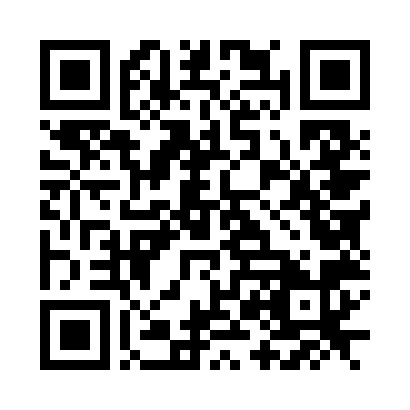

In [39]:
github = qrcode.make('https://github.com/leopold-terpereau/sha-256-python')
github